# BioImage similarity example

## Setup

In [1]:
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")
import tiledb
import PIL

from tiledb.vector_search.object_api import object_index
from tiledb.vector_search.object_readers import BioImageDirectoryReader
from tiledb.vector_search.embeddings import ImageResNetV2Embedding

bioimg_group_uri = "tiledb://PathoPixel-Innov-Demo/b8936ebf-4a4b-4cba-9c73-1fb0327ed9b4"
index_uri = "/tmp/bioimg_demo/index"

config = tiledb.cloud.Config().dict()


## Create vector search index

In [2]:
reader = BioImageDirectoryReader(
    search_uri=bioimg_group_uri, 
    level=2, 
    object_crop_shape=(200, 200),
)
embedding = ImageResNetV2Embedding()

# from tiledb.vector_search.embeddings.huggingface_auto_image_embedding import HuggingfaceAutoImageEmbedding
# embedding = HuggingfaceAutoImageEmbedding(
#     model_name_or_path="google/vit-base-patch16-224",
#     dimensions=768,
#     batch_size=32,
# )
vfs = tiledb.VFS(config=config)
if vfs.is_dir(index_uri):
    vfs.remove_dir(index_uri)
vfs.create_dir(index_uri)

index = object_index.create(
    uri=index_uri,
    index_type="IVF_FLAT",
    object_reader=reader,
    embedding=embedding,
    config=config,
)

### Ingest images

In [3]:
index.update_index(
    max_tasks_per_stage=5,
    workers=5,
    verbose=True,
    files_per_partition=1,
    config=config,
)

15/15 [==============================] - 8s 541ms/step


## Query

### Image display utils

In [35]:
from tiledb.bioimg.openslide import TileDBOpenSlide

# loaded_images = {}
def load_image(image_uri):
    if image_uri in loaded_images:
        return
    print(f"Loading image: {image_uri}")
    with tiledb.scope_ctx(ctx_or_config=config):
        slide = TileDBOpenSlide(image_uri)
        level_dimensions = slide.level_dimensions[reader.level]
        loaded_images[image_uri] = slide.read_region((0, 0), reader.level, level_dimensions)

def display_related_image_with_rectangle(metadata, image_id, related_image_id=-1):
    from PIL import Image, ImageFont, ImageDraw, ImageEnhance
    scale_down=6
    if related_image_id == -1:
        image_uri = metadata["image_uri"][image_id]
    else:
        image_uri = metadata["image_uri"][image_id][related_image_id]
    load_image(image_uri)
    image = loaded_images[image_uri]
    im = PIL.Image.fromarray(image)
    width, height = im.size
    width=int(width/scale_down)
    height=int(height/scale_down)
    im = im.resize((width,height), resample=PIL.Image.NEAREST)

    draw = ImageDraw.Draw(im)
    if related_image_id == -1:
         location = metadata["location"][image_id]
    else:
         location = metadata["location"][image_id][related_image_id]
    draw.rectangle(xy=[
        (int(location[2]/scale_down), int(location[0]/scale_down)), 
        (int(location[3]/scale_down), int(location[1]/scale_down))
        ], outline="red", width=2)
    display(im)
    cropped_image = image[location[0]:location[1], location[2]:location[3]]
    return {"image": [cropped_image.flatten()], "shape": [np.array(cropped_image.shape, dtype=np.uint32)]}

### Open vector index

In [5]:
index = object_index.ObjectIndex(index_uri, load_metadata_in_memory=False)

### Pick a query image

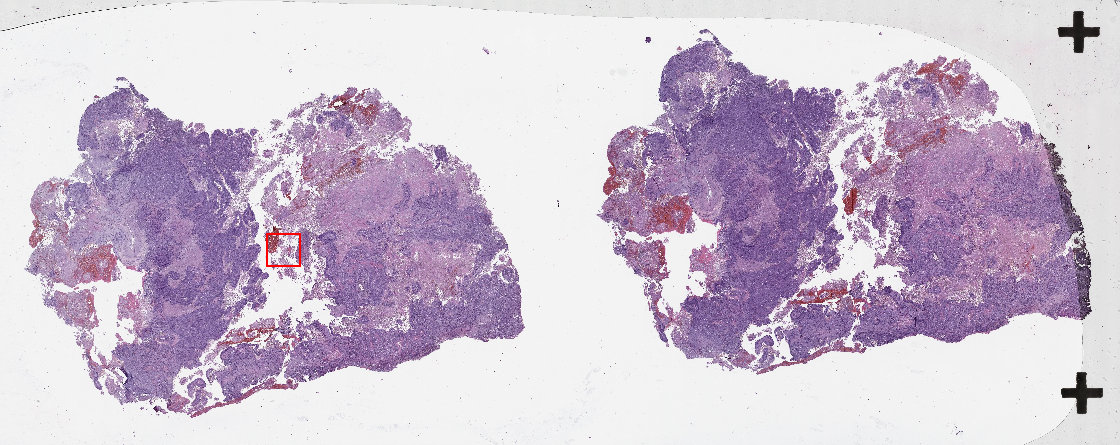

In [36]:
query_image = "tiledb://PathoPixel-Innov-Demo/b6a967b3-e48a-443a-ba13-9705301fb601"
dim_0_start = 1400
dim_1_start = 1600
query_external_id = abs(hash(f"{query_image}_{dim_0_start}_{dim_1_start}"))
with tiledb.open(index.object_metadata_array_uri, "r") as metadata_array:
    query_image = display_related_image_with_rectangle(metadata_array[query_external_id], 0)

### Search for similar images

1/1 [==============================] - 0s 64ms/step
tiledb://PathoPixel-Innov-Demo/eaa13360-dadb-4e17-9868-a159afae4b21


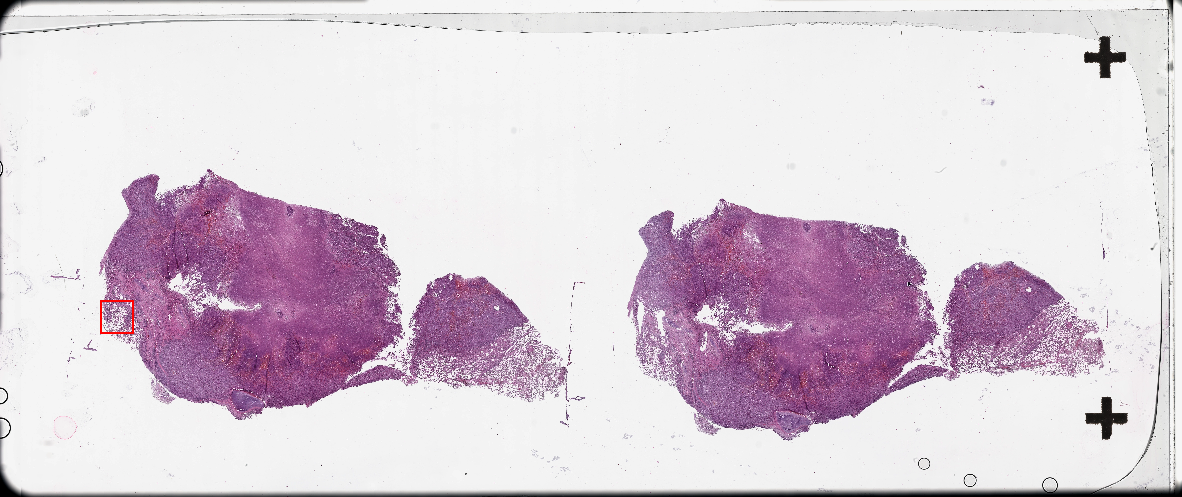

tiledb://PathoPixel-Innov-Demo/0a66a42b-d2a2-4e1c-80b8-33f12e224e7c


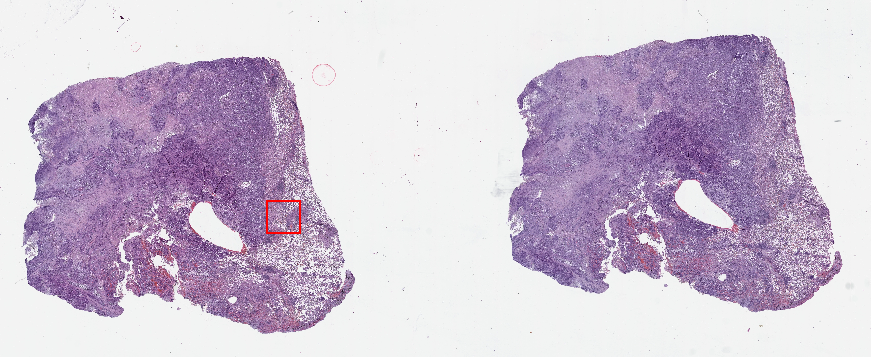

tiledb://PathoPixel-Innov-Demo/0a66a42b-d2a2-4e1c-80b8-33f12e224e7c


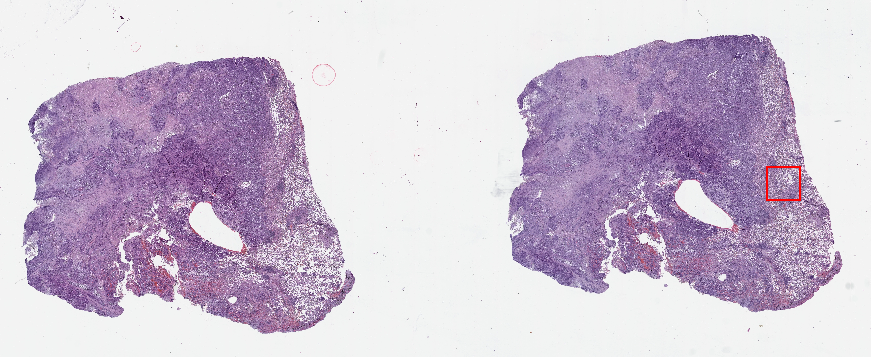

tiledb://PathoPixel-Innov-Demo/584397fb-a425-4aaa-a770-690218d05f47


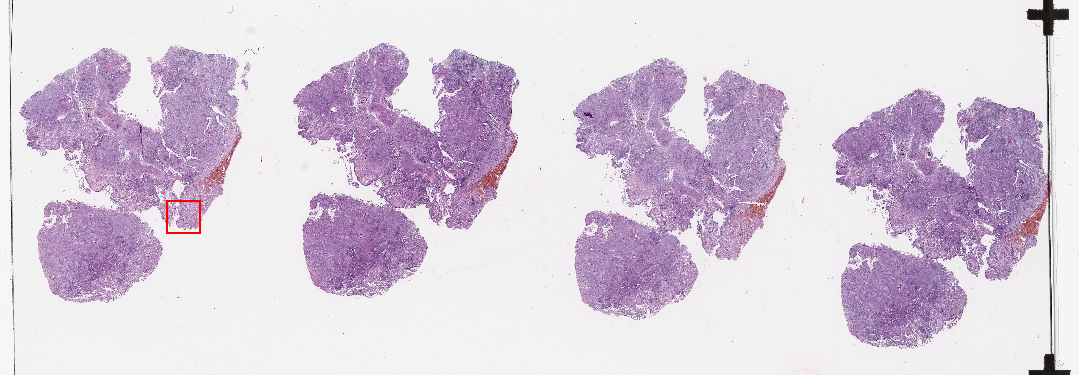

In [37]:
distances, image_ids, metadata = index.query(
                                query_image, 
                                k=5, 
                                nprobe=10,
                                return_objects=False,
                            )
for image_id in range(image_ids.shape[0]):
    for related_image_id in range(1, image_ids.shape[1]):
        print(metadata["image_uri"][image_id][related_image_id])
        display_related_image_with_rectangle(metadata, image_id, related_image_id)
